<a href="https://colab.research.google.com/github/IshaqKHATTAK/Natural-Language-Processing/blob/main/NLP_lab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()


import re
import string 

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud


In [101]:
df = pd.read_csv('tweets.csv',nrows = 500)
#medium_data = medium_data.iloc[:1000,:]
df.head()

user_name                                               text  \
0           Bohmle  #GPT4 for FREE. \nNo its not a clickbait, @Qol...   
1              NaN                                      AI enthusiast   
2     Dan Bruno AI  ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3  Georgiana Comsa  New: @JWVance's post about 5 #startups (includ...   
4     Bitone Great  🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...   

               user_location  \
0                  Carkingga   
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   
3                  Palo Alto   
4                  Hong Kong   

                                    user_description  \
0                                                NaN   
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created  user_followers user_friends  \
0                        NaN             NaN          NaN   
1                      349.0           611.0        False   
2  2021-05-19 01:19:32+00:00           470.0        157.0   
3  2008-12-24 09:32:23+00:00          3864.0       1883.0   
4  2022-11-21 04:42:18+00:00          1517.0        506.0   

             user_favourites         user_verified                       date  \
0                        NaN                   NaN                        NaN   
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   
3                       2415                 False  2023-05-17 18:10:25+00:00   
4                         64                 False  2023-05-17 18:09:39+00:00   

                           hashtags           source  
0                               NaN              NaN  
1                               NaN              NaN  
2       ['chatgpt', 'AI', 'openAI']          dlvr.it  
3         ['startups', 'startup50']  Twitter Web App  
4  ['Binance', 'Short', 'GHSTUSDT']             rsi1

In [102]:
print('Rows              :',df.shape[0])
print('Columns           :',df.shape[1])
print('\nFeatures        :\n',df.columns.tolist())
print('\nMissing values  :',df.isna().sum().values.sum())
print('\nUnique values   :',df.nunique())

Rows              : 500
Columns           : 12

Features        :
 ['user_name', 'text', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source']

Missing values  : 276

Unique values   : user_name           392
text                496
user_location       234
user_description    372
user_created        392
user_followers      326
user_friends        343
user_favourites     344
user_verified         2
date                468
hashtags            213
source               57
dtype: int64


In [103]:
#Here new feature "sentiment" is created. corresponding to each tweet text.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

analyser=SentimentIntensityAnalyzer()
scores=[]
for i in range(len(df['text'])):
    score=analyser.polarity_scores(df['text'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment']=pd.Series(np.array(sentiment))

In [104]:
# Sentiment count
temp=df.groupby('sentiment')['text'].count().reset_index().sort_values(by='sentiment',ascending=False)
temp.style.background_gradient(cmap='Blues')

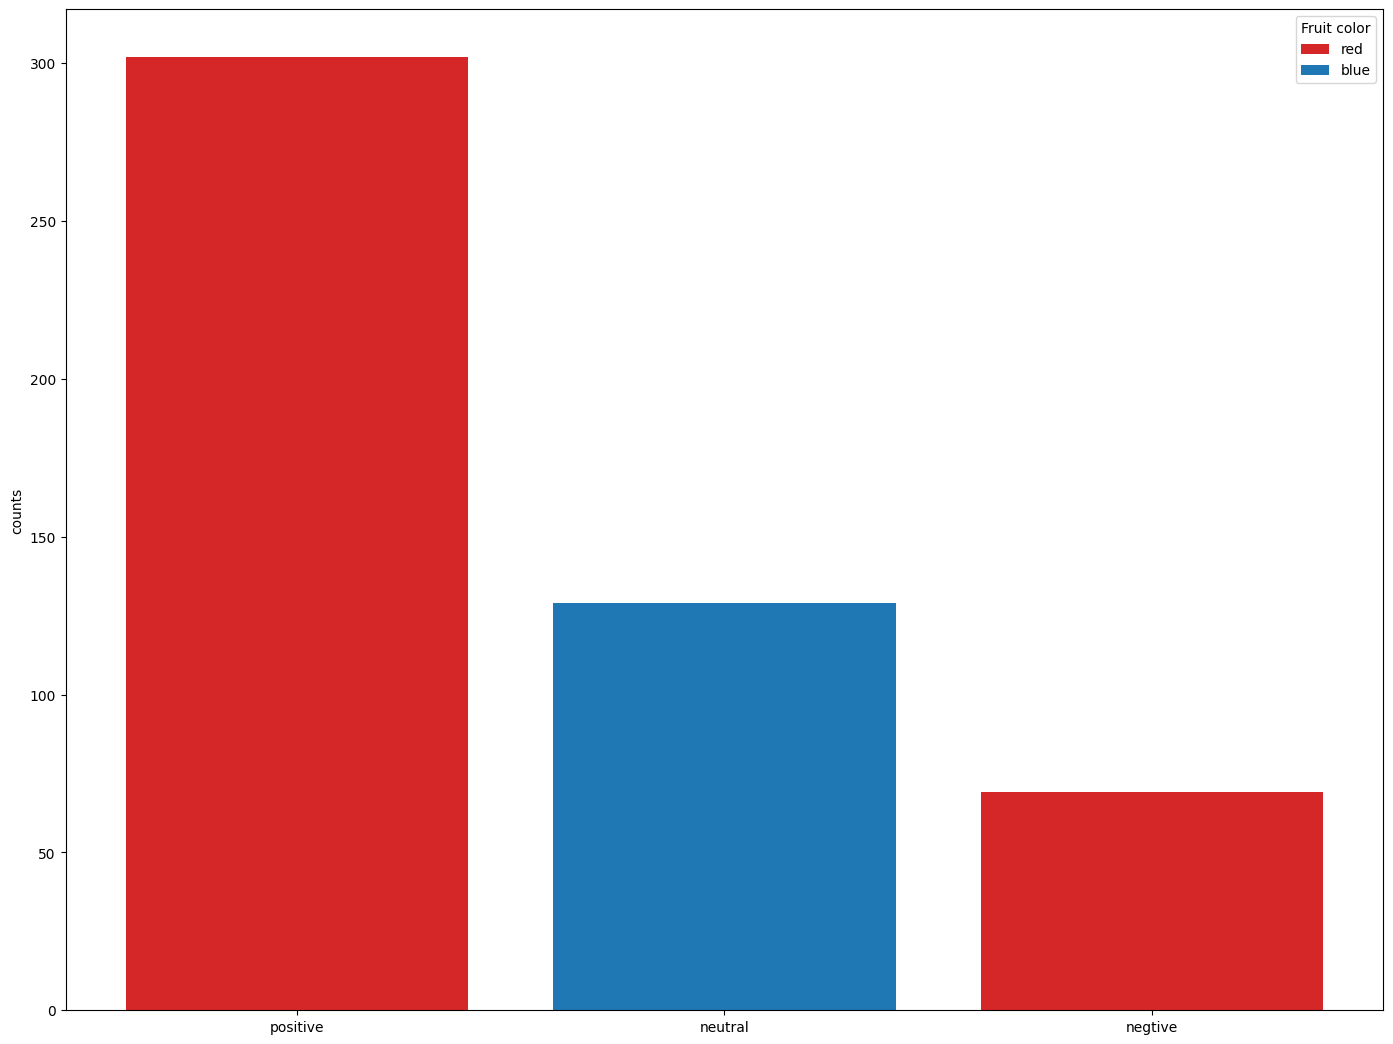

In [105]:


fig, ax = plt.subplots()

fruits = ['positive', 'neutral', 'negtive']
counts = [302, 129, 69]
bar_labels = ['red', 'blue', '_red']
bar_colors = ['tab:red', 'tab:blue', 'tab:red']

ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('counts')

ax.legend(title='Fruit color')

plt.show()

**most hastags: the top 30 hashtags in the text data**

In [106]:
df['hashtags']=df['hashtags'].fillna('[]')

all_hashtags=[]
for i in range(len(df['hashtags'])):
    a=df['hashtags'][i].strip('][').split(',')
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No hashtags' if x=='' else x for x in all_hashtags]

all_hashtags=pd.Series(np.array(all_hashtags))
print('There are {} instances of tweets in which No hashtags were used'.format(all_hashtags.value_counts()[1]))

common_hashtags=all_hashtags.value_counts().drop(labels='No hashtags')[:30].rename_axis('Common Hashtags').reset_index(name='count')
fig=px.treemap(common_hashtags,path=['Common Hashtags'],values='count',title='Top 30 Common Hashtags')
fig.show()

There are 132 instances of tweets in which No hashtags were used


**Sources distribution of tweets differnt sources of tweets**

In [107]:
data_=df['source'].value_counts().reset_index()

trace1=go.Bar(x=['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android','LinkedIn', 'HubSpot', 'IFTTT', 
                 'Hypefury', 'Sprout Social','Revive Social App', 'Buffer'],
              y=data_['source'],marker=dict(color='rgb(250,13,92)',
              line=dict(color='rgb(0,0,0)',width=1.5)),text=data_['source'],textposition='outside')

layout=go.Layout(template='plotly_dark',title='Top 10 Most Source Disrtibution Of Tweets',xaxis=dict(title='Source'),
                 yaxis=dict(title='Count'),height=700)
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

**tweets from ferified account on shese platofrm**

In [108]:
data_verified=df[df['user_verified']==True].reset_index()
data_not_verified=df[df['user_verified']==False].reset_index()

In [109]:
data_=data_verified['source'].value_counts().reset_index()

trace1=go.Bar(x=['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android','LinkedIn', 'HubSpot', 'IFTTT', 
                 'Hypefury', 'Sprout Social','Revive Social App', 'Buffer',],y=data_['source'],
            marker=dict(color='rgb(250,13,92)',line=dict(color='rgb(0,0,0)',width=1.5)),text=data_['source'],
             textposition='outside')
layout=go.Layout(template='plotly_dark',title='Top 20 Most Source Distribution of Twwets From Verified Accounts',xaxis=dict(title='Source'),
                yaxis=dict(title='Count'),height=650)
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

**tweet sentiment on location based positive tweet and negtive tweet locations**

In [110]:
df['user_location']=df['user_location'].fillna('')

postive_tweet=df[df['sentiment']=='Positive'].reset_index()
negative_tweet=df[df['sentiment']=='Negative'].reset_index()
neutral_tweet=df[df['sentiment']=='Neutral'].reset_index()

pos_location=postive_tweet['user_location']
neg_location=negative_tweet['user_location']
neu_location=neutral_tweet['user_location']

common=set(pos_location).intersection(set(neg_location)).intersection(set(neu_location))
common_list=list(common)

common_words=neg_location.value_counts().drop(labels=common_list)[:10].rename_axis('common negative location').reset_index(name='count')
fig=px.treemap(common_words,path=['common negative location'],values='count',title='10 Top Unique negative Tweets Location')
fig.show()

common_words=pos_location.value_counts().drop(labels=common_list)[:10].rename_axis('common positive location').reset_index(name='count')
fig=px.treemap(common_words,path=['common positive location'],values='count',title='10 Top Unique positive Location')
fig.show()

common_words=neu_location.value_counts().drop(labels=common_list)[:10].rename_axis('common neutral location').reset_index(name='count')
fig=px.treemap(common_words,path=['common neutral location'],values='count',title='10 top Unique Neutral Location')
fig.show()

**users whose followers are in thousand**

Text(0.5, 1.0, 'Followers')

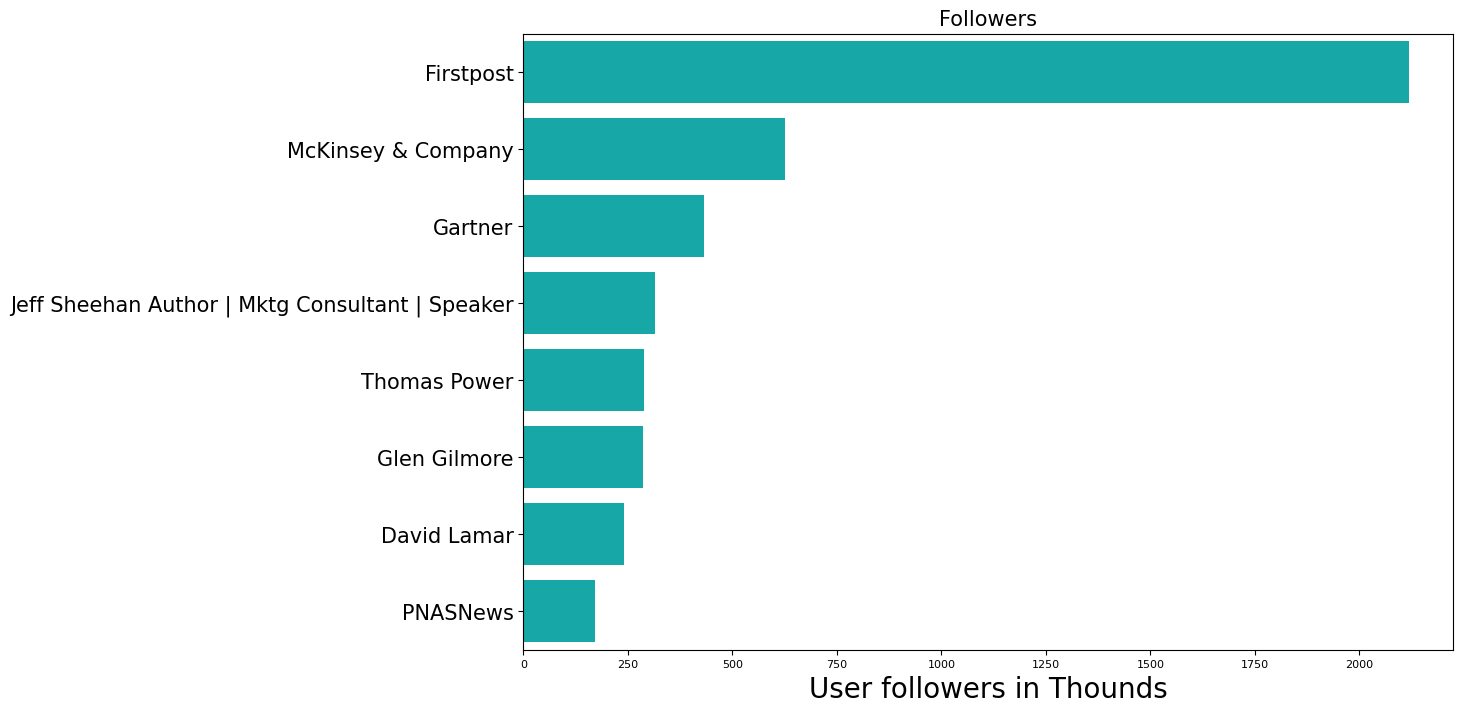

In [111]:
most_pop=df.sort_values('user_followers',ascending=False)[['user_name','user_followers']].head(12)

most_pop['user_followers1']=most_pop['user_followers']/1000


plt.figure(figsize=(12,8))

sns.barplot(data=most_pop, y='user_name',x='user_followers1',color='c')
plt.xticks(fontsize=8,rotation=0)
plt.yticks(fontsize=15,rotation=0)
plt.xlabel('User followers in Thounds',fontsize=20)
plt.ylabel('')
plt.title('Followers',fontsize=15)

#Pre-processing and cleaning

In [112]:
#remove duplicate if any
df = df.drop_duplicates()

In [113]:
print(df.isna().sum())

user_name            1
text                 0
user_location        0
user_description    27
user_created         1
user_followers       1
user_friends         1
user_favourites      1
user_verified        1
date                 1
hashtags             0
source               2
sentiment            0
dtype: int64


In [114]:
#drop missing vales
df = df.dropna()

In [115]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sw = stopwords.words('english')
ps = PorterStemmer()
wl = WordNetLemmatizer()
import re
import emoji

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:

def to_lower(text):
  text = text.lower()
  return text

def replace_emji(text):
  text = emoji.demojize(text, delimiters=('', ''))
  return text

def remove_punctuation(text):
  text = re.sub(r'[^\w\s]','',text)
  return text

def remove_URL(text):
  text = re.sub(r'https?://\S+','',text)
  return text

def remove_special_characters(text):
    no_special_characters = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return no_special_characters

def tokenize_stopword_lematize_stemed(text):
  text = word_tokenize(text) 
  word_list = [w for w in text if w not in sw]
  lematized = [wl.lemmatize(w) for w in word_list]
  stemmed = [ps.stem(w) for w in lematized]
  return ' '.join(stemmed)

In [117]:
df['text'] = data['text'].apply(to_lower)
df['text'] = df['text'].apply(remove_URL)
df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(replace_emji)
df['text'] = df['text'].apply(remove_special_characters)
df['text'] = df['text'].apply(tokenize_stopword_lematize_stemed)
df.head(4)

user_name                                               text  \
2             Dan Bruno AI  chatgpt think 5 crypto coin explod year yahoo ...   
3          Georgiana Comsa  new jwvanc post 5 startup includ vcinityinc 1s...   
4             Bitone Great  get outbin spot recommend short ticker ghstusd...   
5  Matt Pogla | The AI Guy  caught web digit age could use superhero hero ...   

    user_location                                   user_description  \
2  Manchester, NH  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3       Palo Alto  Founder of Silicon Valley PR, award-winning PR...   
4       Hong Kong  #ChatGPT (AI) powered Free Trading Signal! \nL...   
5                  The AI Guy 🤖 Founder of https://t.co/iGFHxb9Er...   

                user_created  user_followers user_friends user_favourites  \
2  2021-05-19 01:19:32+00:00           470.0        157.0            5185   
3  2008-12-24 09:32:23+00:00          3864.0       1883.0            2415   
4  2022-11-21 04:42:18+00:00          1517.0        506.0              64   
5  2023-01-08 16:19:51+00:00          3212.0         87.0              14   

  user_verified                       date                          hashtags  \
2         False  2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3         False  2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4         False  2023-05-17 18:09:39+00:00  ['Binance', 'Short', 'GHSTUSDT']   
5         False  2023-05-17 18:09:14+00:00                                []   

            source sentiment  
2          dlvr.it   Neutral  
3  Twitter Web App  Positive  
4             rsi1   Neutral  
5         Hypefury  Positive

#N_grams analysis

In [118]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

In [119]:
words=df['text'].values

In [120]:
ls=[]
for i in words:
    ls.append(str(i))

(-0.5, 1599.5, 799.5, -0.5)

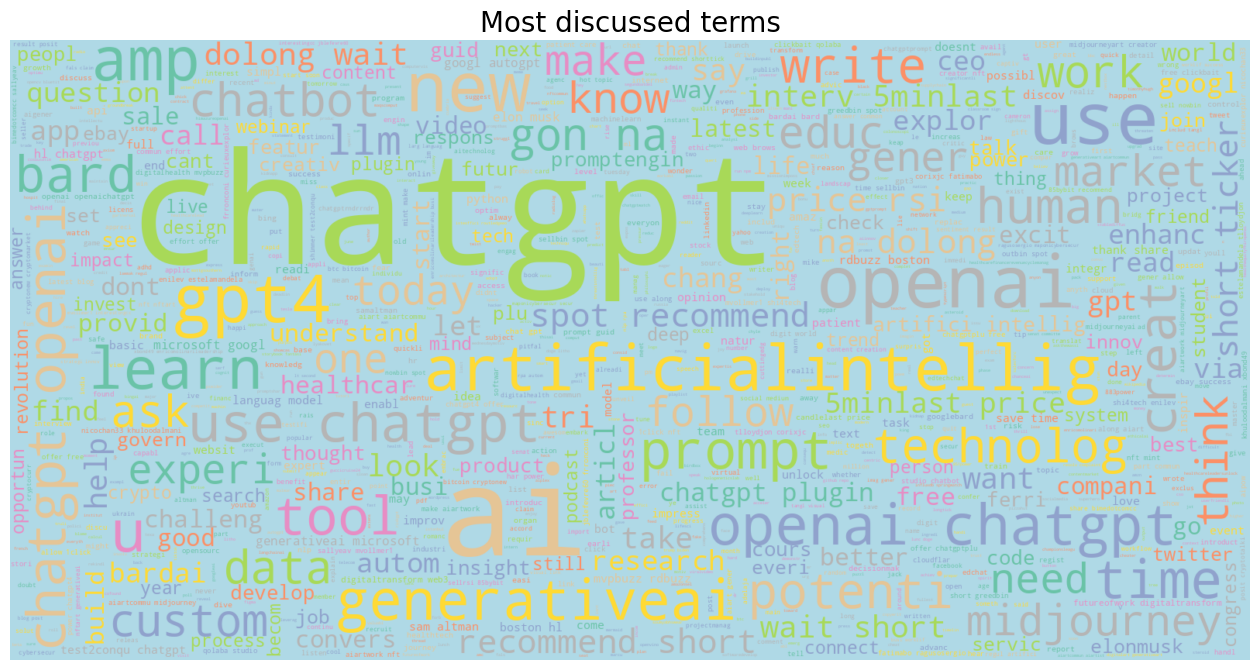

In [121]:
plt.figure(figsize=(16,13))
wc=WordCloud(background_color='lightblue',colormap='Set2',max_words=1000,max_font_size=200,width=1600,height=800)
wc.generate(" ".join(ls))
plt.title('Most discussed terms',fontsize=20)
plt.imshow(wc.recolor(colormap='Set2',random_state=17),alpha=0.98,interpolation='bilinear')
plt.axis('off')

#sentiment analysis

In [126]:
from textblob import TextBlob

sentiment_textblob = [] #positive --> 1 negtive-->2 netral --> 0

def sentiment_TexBlob(text):
  # Create a TextBlob object
  blob = TextBlob(text)
  # Perform sentiment analysis
  sentiment = blob.sentiment.polarity
  if sentiment == 0.0:
    sentiment_textblob.append('neutral')
  elif sentiment < 0:
    sentiment_textblob.append('negtive')
  else:
    sentiment_textblob.append('positive')
  

df['text'].apply(sentiment_TexBlob)


df['sentiment textblob'] = sentiment_textblob
df.head(3)

user_name                                               text  \
2     Dan Bruno AI  chatgpt think 5 crypto coin explod year yahoo ...   
3  Georgiana Comsa  new jwvanc post 5 startup includ vcinityinc 1s...   
4     Bitone Great  get outbin spot recommend short ticker ghstusd...   

    user_location                                   user_description  \
2  Manchester, NH  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3       Palo Alto  Founder of Silicon Valley PR, award-winning PR...   
4       Hong Kong  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created  user_followers user_friends user_favourites  \
2  2021-05-19 01:19:32+00:00           470.0        157.0            5185   
3  2008-12-24 09:32:23+00:00          3864.0       1883.0            2415   
4  2022-11-21 04:42:18+00:00          1517.0        506.0              64   

  user_verified                       date                          hashtags  \
2         False  2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3         False  2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4         False  2023-05-17 18:09:39+00:00  ['Binance', 'Short', 'GHSTUSDT']   

            source sentiment sentiment textblob  
2          dlvr.it   Neutral            neutral  
3  Twitter Web App  Positive            negtive  
4             rsi1   Neutral            neutral

In [127]:
# Sentiment count using textblob
temp=df.groupby('sentiment textblob')['text'].count().reset_index().sort_values(by='sentiment textblob',ascending=False)
temp.style.background_gradient(cmap='Blues')

In [136]:
# Sentiment count using VADER
temp=df.groupby('sentiment')['text'].count().reset_index().sort_values(by='sentiment',ascending=False)
temp.style.background_gradient(cmap='Blues')

#Feature engineering

In [153]:
def sent_len(text):
  return len(text)

def word_len(text):
  return len(word_tokenize(text))

def space_len(text):
  c=0
  for i in text:
      if(i.isspace()):
          c+=1
  return c
  
def char_len(text):
  return sum(not chr.isspace() for chr in text)

  import re

def count_words_with_letter(test_str, letter='M'):
	words = test_str.split()	
	# Use re.match to check if the specified letter is present in each word
	return sum([1 for word in words if re.match(f'.*{letter}.*', word)])
	


In [155]:
df['sent length'] = df['text'].apply(sent_len)
df['word length'] = df['text'].apply(word_len)
df['spaces'] = df['text'].apply(space_len)
df['charate length'] = df['text'].apply(char_len)
df['letter words'] = df['text'].apply(count_words_with_letter)
df.head(3)

user_name                                               text  \
2     Dan Bruno AI  chatgpt think 5 crypto coin explod year yahoo ...   
3  Georgiana Comsa  new jwvanc post 5 startup includ vcinityinc 1s...   
4     Bitone Great  get outbin spot recommend short ticker ghstusd...   

    user_location                                   user_description  \
2  Manchester, NH  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3       Palo Alto  Founder of Silicon Valley PR, award-winning PR...   
4       Hong Kong  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created  user_followers user_friends user_favourites  \
2  2021-05-19 01:19:32+00:00           470.0        157.0            5185   
3  2008-12-24 09:32:23+00:00          3864.0       1883.0            2415   
4  2022-11-21 04:42:18+00:00          1517.0        506.0              64   

  user_verified                       date                          hashtags  \
2         False  2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3         False  2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4         False  2023-05-17 18:09:39+00:00  ['Binance', 'Short', 'GHSTUSDT']   

            source sentiment sentiment textblob  sent length  word length  \
2          dlvr.it   Neutral            neutral           70           12   
3  Twitter Web App  Positive            negtive          175           27   
4             rsi1   Neutral            neutral          150           19   

   spaces  charate length  letter words  
2      11              59             0  
3      26             149             0  
4      18             132             0

#Vectorization

In [156]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer()
tfidf.fit(df['text'])

tfidf_vec_df = tfidf.transform(df['text'])


In [157]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
vec = cv.fit(df['text'])

cv_vec_df = vec.transform(df['text'])


In [161]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Convert the corpus to TaggedDocuments
tagged_corpus = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(data['text'])]

# Train the Doc2Vec model
model = Doc2Vec(tagged_corpus, vector_size=50, window=2, min_count=1, workers=4, epochs=100)

# Get the vector representation of the first document
d2v_vec_df = model.infer_vector(df['text'])


#Feature selection

In [162]:
text_col = df['text']


In [163]:
df =df.drop(['text'], axis=1)

Index(['user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'sentiment', 'sentiment textblob',
       'sent length', 'word length', 'spaces', 'charate length',
       'letter words'],
      dtype='object')

In [166]:
subset = df.columns
corr = df[subset].corr()
corr

user_followers  sent length  word length    spaces  \
user_followers        1.000000     0.014867     0.014202  0.014202   
sent length           0.014867     1.000000     0.892241  0.892241   
word length           0.014202     0.892241     1.000000  1.000000   
spaces                0.014202     0.892241     1.000000  1.000000   
charate length        0.014695     0.997750     0.859959  0.859959   
letter words               NaN          NaN          NaN       NaN   

                charate length  letter words  
user_followers        0.014695           NaN  
sent length           0.997750           NaN  
word length           0.859959           NaN  
spaces                0.859959           NaN  
charate length        1.000000           NaN  
letter words               NaN           NaN

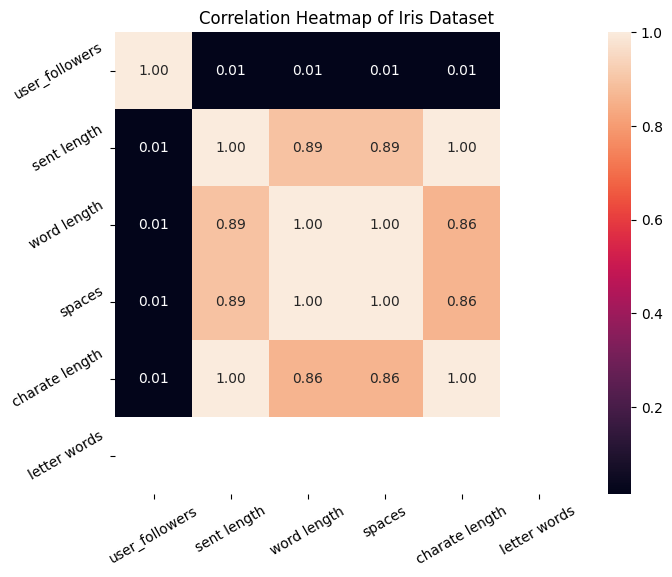

In [167]:
# Create correlation heatmap
plt.figure(figsize=(8,6))
plt.title('Correlation Heatmap of Dataset')
a = sns.heatmap(corr, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()    

In [168]:
 # Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
upper  

user_followers  sent length  word length    spaces  \
user_followers             NaN     0.014867     0.014202  0.014202   
sent length                NaN          NaN     0.892241  0.892241   
word length                NaN          NaN          NaN  1.000000   
spaces                     NaN          NaN          NaN       NaN   
charate length             NaN          NaN          NaN       NaN   
letter words               NaN          NaN          NaN       NaN   

                charate length  letter words  
user_followers        0.014695           NaN  
sent length           0.997750           NaN  
word length           0.859959           NaN  
spaces                0.859959           NaN  
charate length             NaN           NaN  
letter words               NaN           NaN

In [169]:
# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['word length', 'spaces', 'charate length']


In [173]:
# Drop Marked Features
corr_df = df.drop(to_drop, axis=1)


In [178]:
corr_df.head(3)

user_name   user_location  \
2     Dan Bruno AI  Manchester, NH   
3  Georgiana Comsa       Palo Alto   
4     Bitone Great       Hong Kong   

                                    user_description  \
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created  user_followers user_friends user_favourites  \
2  2021-05-19 01:19:32+00:00           470.0        157.0            5185   
3  2008-12-24 09:32:23+00:00          3864.0       1883.0            2415   
4  2022-11-21 04:42:18+00:00          1517.0        506.0              64   

  user_verified                       date                          hashtags  \
2         False  2023-05-17 18:11:03+00:00       ['chatgpt', 'AI', 'openAI']   
3         False  2023-05-17 18:10:25+00:00         ['startups', 'startup50']   
4         False  2023-05-17 18:09:39+00:00  ['Binance', 'Short', 'GHSTUSDT']   

            source sentiment sentiment textblob  sent length  letter words  
2          dlvr.it   Neutral            neutral           70             0  
3  Twitter Web App  Positive            negtive          175             0  
4             rsi1   Neutral            neutral          150             0

In [184]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['sentiment'] = le.fit_transform(df['sentiment'])

#prepare sets and models

In [189]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(tfidf_vec_df.toarray(), corr_df['sentiment'])

In [191]:
#TextBlob + TF-IDF + LinearSVC  tfidf_vec
from sklearn.svm import SVC

SVM = SVC()
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)

In [193]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08        25
     Neutral       0.67      0.08      0.15        24
    Positive       0.61      1.00      0.75        69

    accuracy                           0.61       118
   macro avg       0.76      0.37      0.33       118
weighted avg       0.70      0.61      0.49       118



In [194]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [195]:
# Define the models to train and test
models = [
    ("MultinomialNB", MultinomialNB()),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("Decision Tree", DecisionTreeClassifier())
]

In [197]:
# Train and evaluate models on the TF-IDF vectors
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}\n{classification_report(y_test, y_pred)}\n")

Model: MultinomialNB
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        25
     Neutral       0.33      0.08      0.13        24
    Positive       0.62      1.00      0.76        69

    accuracy                           0.60       118
   macro avg       0.32      0.36      0.30       118
weighted avg       0.43      0.60      0.47       118


Model: Random Forest
              precision    recall  f1-score   support

    Negative       1.00      0.12      0.21        25
     Neutral       0.70      0.29      0.41        24
    Positive       0.64      0.97      0.77        69

    accuracy                           0.65       118
   macro avg       0.78      0.46      0.47       118
weighted avg       0.73      0.65      0.58       118


Model: Decision Tree
              precision    recall  f1-score   support

    Negative       0.75      0.24      0.36        25
     Neutral       0.45      0.54      0.49        24
    Positi

In [200]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(cv_vec_df.toarray(), corr_df['sentiment'])

In [201]:
# Train and evaluate models on the TF-IDF vectors
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}\n{classification_report(y_test, y_pred)}\n")

Model: MultinomialNB
              precision    recall  f1-score   support

    Negative       0.43      0.14      0.21        21
     Neutral       0.32      0.24      0.27        34
    Positive       0.56      0.76      0.64        63

    accuracy                           0.50       118
   macro avg       0.44      0.38      0.38       118
weighted avg       0.47      0.50      0.46       118


Model: Random Forest
              precision    recall  f1-score   support

    Negative       1.00      0.10      0.17        21
     Neutral       0.67      0.12      0.20        34
    Positive       0.56      0.98      0.72        63

    accuracy                           0.58       118
   macro avg       0.74      0.40      0.36       118
weighted avg       0.67      0.58      0.47       118


Model: Decision Tree
              precision    recall  f1-score   support

    Negative       0.50      0.29      0.36        21
     Neutral       0.33      0.18      0.23        34
    Positi

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(cv_vec_df.toarray(), corr_df['sentiment'])